# GeoSpatial Data Project

#### Objective:
This project aims to find the best possible location for a technology startup based on a given database, and certain previously established requirements.

In [567]:
import pandas as pd
from pandas import json_normalize

import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster

import requests 
import json
import os
from dotenv import load_dotenv

from pymongo import MongoClient
import pandas as pd

import matplotlib.pyplot as plt


import src.haversine_function as distance
from flexitext import flexitext



In [2]:
client = MongoClient("localhost:27017")
db = client["ironhack"]
c = db.get_collection("Crunchbase")

#### For this, we have a database of various companies from which I will select those that meet the following conditions:

- There must be some nearby companies that also do design and tech
        
             So I explore the database filtering it by description, tag_list, name, or category code, looking for matches for this condition.   
        
        
- Developers like to be near successful tech startups that have raised at least 1 Million dollars. 

               to fulfill this, I looked for companies that have less than 150 employees (to be Startups), and that have raised more than 1 million dollars




In [3]:
#DESIGN or tech companies nearby
filter_10 = {"description": {"$regex": "design"}}
filter_11 = {"description": {"$regex": "technology"}}
filter_12 = {"description": {"$regex": "software"}}

filter_2 = {"tag_list": {"$regex": "design"}}

filter_3 = {"name": {"$regex": "design"}}

filter_40 = {"category_code": {"$regex": "design"}}
filter_41 = {"category_code": {"$regex": "games_video"}}
filter_42 = {"category_code": {"$regex": "web"}}
filter_43 = {"category_code": {"$regex": "mobile"}}
filter_44 = {"category_code": {"$regex": "photo_video"}}

#Near to SUCCESSFUL tech startups
filter_50 = {"total_money_raised": {"$regex": "M"}}
filter_51 = {"total_money_raised": {"$regex": "B"}}
filter_52 = {"total_money_raised": {"$regex": "^k"}}
filter_53 = {"total_money_raised":{ "$not": {"$regex": "/$0/"}}}




all_conditions = [filter_10, filter_11, filter_12, filter_2, filter_3, filter_40, 
                  filter_41, filter_42, filter_43, filter_44, filter_50, filter_51, filter_52, filter_53]

In [4]:
projection = {"name": 1, 
              "number_of_employees": 1,
              "total_money_raised": 1,
              "offices.country_code": 1,
              "offices.city": 1,
              "offices.latitude": 1,
              "offices.longitude": 1,
              "_id":0}

result = list(c.find({"$or": all_conditions,
                      
                "number_of_employees": {"$lte": 150 } # STARTUP
                     
                     }, projection))

df = pd.DataFrame(result)

In [5]:
df

,name,number_of_employees,total_money_raised,offices
0,Wetpaint,47,$39.8M,"[{'city': 'Seattle', 'country_code': 'USA', 'l..."
1,Digg,60,$45M,"[{'city': 'San Francisco', 'country_code': 'US..."
2,Geni,18,$16.5M,"[{'city': 'West Hollywood', 'country_code': 'U..."
3,Fox Interactive Media,0,$0,"[{'city': 'Beverly Hills', 'country_code': 'US..."
4,Scribd,50,$25.8M,"[{'city': 'San Francisco', 'country_code': 'US..."
...,...,...,...,...
8130,OfficialVirtualDJ,102,€25M,"[{'city': 'London', 'country_code': 'GBR', 'la..."
8131,Eazeeloans,25,$0,"[{'city': 'Mumbai', 'country_code': 'IND', 'la..."
8132,DocASAP,7,$800k,"[{'city': 'New York', 'country_code': 'USA', '..."
8133,cotralis,1,$0,[]


Now, if I want to know the location of the offices that I am filtering,I will have to extract data from the "offices" column
  

In [7]:
col_to_extract = df['offices']
col_to_extract[0][0]

{'city': 'Seattle',
 'country_code': 'USA',
 'latitude': 47.603122,
 'longitude': -122.333253}

In [8]:
def extraction(col, new_col, data):    
    list_ = []
    for i in range(len(col)):
        try:           
            list_.append(col[i][0][data])             
        except:
            list_.append("null")
    df[new_col]= list_
    return

In [9]:
extraction(col_to_extract, "Country", "country_code")
extraction(col_to_extract, "City", "city")
extraction(col_to_extract, "lat", "latitude")
extraction(col_to_extract, "lon", "longitude")

In [10]:
df

,name,number_of_employees,total_money_raised,offices,Country,City,lat,lon
0,Wetpaint,47,$39.8M,"[{'city': 'Seattle', 'country_code': 'USA', 'l...",USA,Seattle,47.603122,-122.333253
1,Digg,60,$45M,"[{'city': 'San Francisco', 'country_code': 'US...",USA,San Francisco,37.764726,-122.394523
2,Geni,18,$16.5M,"[{'city': 'West Hollywood', 'country_code': 'U...",USA,West Hollywood,34.090368,-118.393064
3,Fox Interactive Media,0,$0,"[{'city': 'Beverly Hills', 'country_code': 'US...",USA,Beverly Hills,34.076179,-118.39417
4,Scribd,50,$25.8M,"[{'city': 'San Francisco', 'country_code': 'US...",USA,San Francisco,37.789634,-122.404052
...,...,...,...,...,...,...,...,...
8130,OfficialVirtualDJ,102,€25M,"[{'city': 'London', 'country_code': 'GBR', 'la...",GBR,London,None,None
8131,Eazeeloans,25,$0,"[{'city': 'Mumbai', 'country_code': 'IND', 'la...",IND,Mumbai,None,None
8132,DocASAP,7,$800k,"[{'city': 'New York', 'country_code': 'USA', '...",USA,New York,None,None
8133,cotralis,1,$0,[],null,null,null,null


In [11]:
df.drop(['offices'],axis =1, inplace=True)
df.dropna(inplace=True)
df = df[df["Country"] != "null"]

In [12]:
df

,name,number_of_employees,total_money_raised,Country,City,lat,lon
0,Wetpaint,47,$39.8M,USA,Seattle,47.603122,-122.333253
1,Digg,60,$45M,USA,San Francisco,37.764726,-122.394523
2,Geni,18,$16.5M,USA,West Hollywood,34.090368,-118.393064
3,Fox Interactive Media,0,$0,USA,Beverly Hills,34.076179,-118.39417
4,Scribd,50,$25.8M,USA,San Francisco,37.789634,-122.404052
...,...,...,...,...,...,...,...
8123,InstantQ,3,$0,USA,Sunnyvale,37.369195,-122.036849
8125,NextLabs,100,$0,USA,San Mateo,37.553121,-122.301534
8127,acrossair,6,$0,GBR,London,51.517742,-0.116537
8128,MyChances,2,$0,USA,Reno,39.394564,-119.812079


In [13]:
df["Country"].value_counts()[:1]

USA    3437
Name: Country, dtype: int64

In [14]:
df['City'].where(df['Country'] == 'USA').value_counts()[:3]

San Francisco    320
New York         249
Seattle           89
Name: City, dtype: int64

In [15]:
# df_SanF = df[df['City'] == 'San Francisco']
df_SanF = df[df['City'] == 'San Francisco']

# TubeSpree, Bizroof
# FeVote
# Lending Karma
# ARX
# Ecolect

In [16]:
df_SanF

,name,number_of_employees,total_money_raised,Country,City,lat,lon
1,Digg,60,$45M,USA,San Francisco,37.764726,-122.394523
4,Scribd,50,$25.8M,USA,San Francisco,37.789634,-122.404052
8,Powerset,60,$22.5M,USA,San Francisco,37.778613,-122.395289
9,Technorati,35,$32.1M,USA,San Francisco,37.779558,-122.393041
12,Kyte,40,$23.4M,USA,San Francisco,37.788482,-122.409173
...,...,...,...,...,...,...,...
7776,UTOPY,40,$7.5M,USA,San Francisco,37.767575,-122.411157
7821,ZoomSystems,100,$87M,USA,San Francisco,37.781689,-122.391061
7879,Mondo Media,9,$0,USA,San Francisco,37.764169,-122.402021
7902,TwtBks,3,$25k,USA,San Francisco,37.761102,-122.416001


In [18]:
import math


def haversine(coord1, coord2):

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    km = round(km, 3)
    meters = round(meters, 3)
    return meters
    


#### Othe requirements

- 30% of the company staff have at least 1 child.
- Executives like Starbucks A LOT. Ensure there's a starbucks not too far.
- Account managers need to travel a lot.
- Everyone in the company is between 25 and 40, give them some place to go party.
- The CEO is vegan.
- If you want to make the maintenance guy happy, a basketball stadium must be around 10 Km.
- The office dog—"Dobby" needs a hairdresser every month. Ensure there's one not too far away.


In [21]:
load_dotenv()

True

In [22]:
token_for_foursquare = os.getenv("API_Key")

In [23]:
def get_results_from_foursquare (query, location, limit=1):
    
    ll = f"{location[0]}%2C{location[1]}"
    url = f"https://api.foursquare.com/v3/places/search?query={query}&ll={ll}&limit={str(limit)}"

    headers = {
        "accept": "application/json",
        "Authorization": token_for_foursquare,
    }
    
    response = requests.get(url, headers=headers).json()
    
    return response

In [24]:
sanFran_location=[37.7676672,-122.4461183] 
sf_lat = 37.7676672
sf_long = -122.4461183

In [601]:
sanFran_map = Map(location = [sf_lat, sf_long], zoom_start = 13)
sanFran_map

# companies

In [602]:
for index, row in df_SanF.iterrows():
    parks = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}

    icon = Icon (color="blue", opacity = 0.6, prefix = "fa", icon="briefcase", icon_color = "black")    
    
    new_marker = Marker(**parks, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map)

In [603]:
companies_group = folium.FeatureGroup(name=f"company: {df_SanF.shape[1]}")

In [604]:
sanFran_map_HM = Map(location = [sf_lat, sf_long], zoom_start = 13)
HeatMap(data=df_SanF[["lat", "lon"]], 
        radius=25,
       gradient = {0.4: 'blue', 0.65: 'lightblue', 1: 'lightblue'}).add_to(companies_group)

In [605]:
companies_group.add_to(sanFran_map_HM)

In [606]:
sanFran_map_HM

# QUERY = Airports

In [607]:
location_SFO=[37.6399899,-122.3942075]

lat_SFO = 37.639989
lon_SFO = -122.3942075

In [608]:
icon_SFO = Icon(color = "lightred",
            opacity = 0.1,
            prefix = "fa",
            icon = "plane",
            icon_color = "black"
)

In [609]:
airport = Marker(location = [lat_SFO, lon_SFO], tooltip="Airport SFO", icon=icon_SFO)

In [610]:
sanFran_map1 = sanFran_map

In [611]:
airport.add_to(sanFran_map1)

In [622]:
airport.add_to(sanFran_map_HM)

In [612]:
sanFran_map1

In [619]:
bart_metro = [{'station': 'bart_stc_1',
  'lat': 37.789364,
  'lon': -122.4035257,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.4035257, 37.789364]}}},
  
  {'station': 'bart_stc_2',
  'lat': 37.7853959,
  'lon': -122.4076993,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.4076993, 37.7853959]}}},
              
   {'station': 'bart_stc_3',
  'lat': 37.7796468,
  'lon': -122.4132246,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.4132246, 37.7796468]}}},
              
    {'station': 'bart_stc_4',
  'lat':37.7652648,
  'lon': -122.4195441,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.4195441, 37.7652648]}}},
             
    {'station': 'bart_stc_5',
  'lat': 37.7512276,
  'lon': -122.417922,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.417922, 37.7512276]}}},   
           
   {'station': 'bart_stc_6',
  'lat':37.7340611,
  'lon': -122.432054,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.432054, 37.7340611]}}},    
              
              
{'station': 'bart_stc_7',
  'lat':37.705859,
  'lon': -122.4699171,
    'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.4699171, 37.705859]}}}]

In [620]:
for index, row in df_metro.iterrows():
    station = {"location": [row["lat"], row["lon"]], "tooltip": row["station"]}

    icon = Icon (color="lightred", opacity = 0.6, prefix = "fa", icon="subway", icon_color = "black")    
    
    new_marker = Marker(**station, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map_HM)

In [623]:
sanFran_map_HM

In [614]:
df_metro = pd.DataFrame(bart_metro)
df_metro

,station,lat,lon,type
0,bart_stc_1,37.789364,-122.403526,"{'typepoint': {'type': 'Point', 'coordinates':..."
1,bart_stc_2,37.785396,-122.407699,"{'typepoint': {'type': 'Point', 'coordinates':..."
2,bart_stc_3,37.779647,-122.413225,"{'typepoint': {'type': 'Point', 'coordinates':..."
3,bart_stc_4,37.765265,-122.419544,"{'typepoint': {'type': 'Point', 'coordinates':..."
4,bart_stc_5,37.751228,-122.417922,"{'typepoint': {'type': 'Point', 'coordinates':..."
5,bart_stc_6,37.734061,-122.432054,"{'typepoint': {'type': 'Point', 'coordinates':..."
6,bart_stc_7,37.705859,-122.469917,"{'typepoint': {'type': 'Point', 'coordinates':..."


In [616]:
metro = db.get_collection("metro")
metro

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ironhack'), 'metro')

In [431]:
metro.insert_many(bart_metro)

In [432]:
metro.find_one()

{'_id': ObjectId('63605a797b2ad5060d8fce15'),
 'station': 'bart_stc_1',
 'lat': 37.789364,
 'lon': -122.4035257,
 'type': {'typepoint': {'type': 'Point',
   'coordinates': [-122.4035257, 37.789364]}}}

In [396]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [617]:
list_nearest_stc=[]
list_nearest_stc_coor=[]
dist_stc=[]

for index, rows in df_SanF.iterrows():
    try:
        lat =  df_SanF['lat'][index]
        lon = df_SanF['lon'][index]
        
        coord1 = [lon, lat]
        query = {"type.typepoint": {
                "$near": {
                    "$geometry": {'type': 'Point', 'coordinates':[lon, lat]}, "$maxDistance": 2000
                }}       
            }
        list_ = list(metro.find(query))
        v1 = list_[0]['station']
        coord2 = [list_[0]['lon'], bart_metro[0]['lat']] 
        
        list_nearest_stc.append(v1)
        list_nearest_stc_coor.append(coord2)
        dist_stc.append(int(round(haversine(coord1, coord2))))
        
    except:
        
        list_nearest_stc.append(float('nan'))
        list_nearest_stc_coor.append(float('nan'))
        dist_stc.append(float('nan'))

In [448]:
len(dist_stc)

320

[nan,
 55,
 1618,
 1428,
 162,
 3570,
 1280,
 255,
 3487,
 733,
 1334,
 993,
 1260,
 1661,
 1661,
 3574,
 nan,
 1274,
 2741,
 1428,
 272,
 402,
 1661,
 352,
 1183,
 nan,
 679,
 1572,
 731,
 734,
 799,
 336,
 868,
 1428,
 522,
 nan,
 1661,
 1277,
 1530,
 3197,
 1294,
 nan,
 55,
 1428,
 949,
 nan,
 404,
 1087,
 2089,
 814,
 582,
 1174,
 1613,
 1866,
 1370,
 427,
 530,
 2866,
 1140,
 3009,
 134,
 nan,
 1661,
 126,
 1239,
 nan,
 113,
 1775,
 1888,
 1140,
 1661,
 195,
 1754,
 932,
 1088,
 1132,
 nan,
 nan,
 1775,
 259,
 3881,
 732,
 562,
 nan,
 1661,
 1225,
 1385,
 88,
 456,
 nan,
 1619,
 1661,
 1385,
 1510,
 nan,
 nan,
 1661,
 2434,
 nan,
 nan,
 1211,
 nan,
 nan,
 1621,
 1661,
 1661,
 3617,
 322,
 nan,
 4528,
 587,
 819,
 2023,
 190,
 3820,
 599,
 nan,
 nan,
 1643,
 551,
 1617,
 2019,
 3897,
 nan,
 513,
 1661,
 543,
 1661,
 459,
 1775,
 284,
 1370,
 1140,
 1957,
 nan,
 1389,
 183,
 1388,
 nan,
 1572,
 272,
 1472,
 1385,
 1028,
 233,
 1556,
 3197,
 nan,
 203,
 343,
 nan,
 233,
 1757,
 1634,

In [57]:

df_SanF.reset_index(inplace = True, drop=True)
df_SanF

,name,number_of_employees,total_money_raised,Country,City,lat,lon
0,Digg,60,$45M,USA,San Francisco,37.764726,-122.394523
1,Scribd,50,$25.8M,USA,San Francisco,37.789634,-122.404052
2,Powerset,60,$22.5M,USA,San Francisco,37.778613,-122.395289
3,Technorati,35,$32.1M,USA,San Francisco,37.779558,-122.393041
4,Kyte,40,$23.4M,USA,San Francisco,37.788482,-122.409173
...,...,...,...,...,...,...,...
315,UTOPY,40,$7.5M,USA,San Francisco,37.767575,-122.411157
316,ZoomSystems,100,$87M,USA,San Francisco,37.781689,-122.391061
317,Mondo Media,9,$0,USA,San Francisco,37.764169,-122.402021
318,TwtBks,3,$25k,USA,San Francisco,37.761102,-122.416001


# QUERY = vegan (The CEO is vegan)

In [452]:
query_21 = "vegan"

In [453]:
response_vegan = get_results_from_foursquare(query_21,sanFran_location)

In [454]:
# Doing the same thing with limit=20

all_vegan = get_results_from_foursquare (query_21, sanFran_location, limit=20)

In [455]:
new_list_vegan = []
for i in all_vegan["results"]:
    
    name = i["name"]
    address = i["location"]["formatted_address"]
    lon = i["geocodes"]["main"]["latitude"]
    lat = i["geocodes"]["main"]["longitude"]
    distance = i['distance']
    
    
    type_ = {"typepoint": 
                          {"type": "Point", 
                           "coordinates": [lat, lon]}}
    
    new_list_vegan.append({"name":name, "lat":lat, "lon":lon, "type":type_, "distance":distance})
    
new_list_vegan[:2]

[{'name': 'Gracias Madre',
  'lat': -122.419145,
  'lon': 37.761621,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.419145, 37.761621]}},
  'distance': 2467},
 {'name': 'Judahlicious',
  'lat': -122.503997,
  'lon': 37.76076,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.503997, 37.76076]}},
  'distance': 5142}]

In [456]:
vegan = db.get_collection("vegan")
vegan

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ironhack'), 'vegan')

In [342]:
vegan.insert_many(new_list_vegan)

In [457]:
vegan.find_one()

{'_id': ObjectId('635fc9e34f45b207b5cf1a0a'),
 'name': 'Gracias Madre',
 'lat': -122.419145,
 'lon': 37.761621,
 'type': {'typepoint': {'type': 'Point',
   'coordinates': [-122.419145, 37.761621]}},
 'distance': 2467}

In [458]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [459]:
list_nearest_vegan=[]
list_nearest_vegan_coor=[]
dist_vegan=[]

for index, rows in df_SanF.iterrows():
    try:
        lat =  df_SanF['lat'][index]
        lon = df_SanF['lon'][index]
        
        coord1 = [lon, lat]
    
        query = {"type.typepoint": {
                "$near": {
                    "$geometry": {'type': 'Point', 'coordinates':[lon, lat]}, "$maxDistance": 2000
                }}       
            }
        list_ = list(vegan.find(query))
        v1 = list_[0]['name']
        coord2 = list_[0]['type']['typepoint']['coordinates']
        
        list_nearest_vegan.append(v1)
        list_nearest_vegan_coor.append(coord2)
        dist_vegan.append(round(haversine(coord1, coord2)))
        
    except:
        
        list_nearest_vegan.append(float('nan'))
        list_nearest_vegan_coor.append(float('nan'))
        dist_vegan.append(float('nan'))
    

In [462]:
dist_vegan

[1452,
 662,
 780,
 575,
 878,
 1331,
 530,
 944,
 428,
 794,
 363,
 1052,
 1221,
 401,
 401,
 1274,
 1535,
 301,
 369,
 575,
 809,
 992,
 401,
 367,
 228,
 nan,
 352,
 495,
 242,
 860,
 925,
 979,
 790,
 575,
 851,
 nan,
 401,
 444,
 496,
 877,
 565,
 nan,
 662,
 575,
 518,
 nan,
 295,
 455,
 118,
 765,
 808,
 570,
 925,
 895,
 841,
 954,
 888,
 302,
 563,
 655,
 727,
 nan,
 401,
 813,
 556,
 43,
 622,
 995,
 725,
 563,
 401,
 884,
 982,
 882,
 424,
 358,
 306,
 nan,
 995,
 608,
 821,
 253,
 828,
 nan,
 401,
 538,
 305,
 778,
 957,
 542,
 915,
 401,
 305,
 1238,
 1537,
 nan,
 401,
 73,
 1179,
 nan,
 666,
 nan,
 1882,
 624,
 401,
 401,
 14,
 732,
 nan,
 405,
 792,
 651,
 337,
 719,
 86,
 736,
 nan,
 nan,
 368,
 839,
 975,
 961,
 215,
 725,
 682,
 401,
 849,
 401,
 1096,
 995,
 535,
 752,
 563,
 373,
 nan,
 281,
 598,
 343,
 401,
 495,
 809,
 192,
 305,
 166,
 468,
 445,
 877,
 nan,
 883,
 911,
 943,
 468,
 1050,
 359,
 518,
 956,
 401,
 1546,
 673,
 637,
 nan,
 651,
 877,
 305,
 769,
 

In [461]:
len(list_nearest_vegan)

320

In [625]:
df2= pd.DataFrame(new_list_vegan)
df2["name"] = "Vegan Food"
df2

,name,lat,lon,type,distance
0,Vegan Food,-122.419145,37.761621,"{'typepoint': {'type': 'Point', 'coordinates':...",2467
1,Vegan Food,-122.503997,37.760760,"{'typepoint': {'type': 'Point', 'coordinates':...",5142
2,Vegan Food,-122.446670,37.770198,"{'typepoint': {'type': 'Point', 'coordinates':...",278
3,Vegan Food,-122.251847,37.847406,"{'typepoint': {'type': 'Point', 'coordinates':...",19220
4,Vegan Food,-122.421752,37.760867,"{'typepoint': {'type': 'Point', 'coordinates':...",2289
5,Vegan Food,-122.405173,37.795717,"{'typepoint': {'type': 'Point', 'coordinates':...",4772
6,Vegan Food,-122.416942,37.781359,"{'typepoint': {'type': 'Point', 'coordinates':...",2990
7,Vegan Food,-122.420939,37.756812,"{'typepoint': {'type': 'Point', 'coordinates':...",2510
8,Vegan Food,-122.276904,37.831280,"{'typepoint': {'type': 'Point', 'coordinates':...",16457
9,Vegan Food,-122.249668,37.828263,"{'typepoint': {'type': 'Point', 'coordinates':...",18506


In [628]:
for index, row in df2.iterrows():
    vegan = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}

    icon = Icon (color="lightgray", opacity = 0.6, prefix = "fa", icon="pagelines", icon_color = "green")    
    
    new_marker = Marker(**vegan, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map1)

In [629]:
sanFran_map1

# QUERY = PARK (30% of the company staff have at least 1 child)

In [466]:
query_10 = "park"

In [467]:
sanFran_location=[37.7676672,-122.4461183] 
sf_lat = 37.7676672
sf_long = -122.4461183


In [468]:
response_park = get_results_from_foursquare(query_10,sanFran_location)

In [469]:
latitude = response_park["results"][0]["geocodes"]["main"]["latitude"]
longitude = response_park["results"][0]["geocodes"]["main"]["longitude"]
address = response_park["results"][0]["location"]["address"]
name = response_park["results"][0]["name"]
distance = response_park["results"][0]['distance']
coord = [latitude, longitude]

print(distance)
print(coord)
print(address)
print(name)

704
[37.764875, -122.438974]
Roosevelt Way
Corona Heights Park


In [470]:
# Doing the same thing with limit=20

all_parks = get_results_from_foursquare (query_10, sanFran_location, limit=20)

In [471]:
new_list_park = []
for i in all_parks["results"]:
    
    name = i["name"]
    address = i["location"]["formatted_address"]
    lat = i["geocodes"]["main"]["latitude"]
    lon = i["geocodes"]["main"]["longitude"]
    distance = i['distance']
    
    
    type_ = {"typepoint": 
                          {"type": "Point", 
                           "coordinates": [lon, lat]}}
    
    new_list_park.append({"name":name, "lat":lat, "lon":lon, "type":type_, "distance":distance})
    
new_list_park[:2]

[{'name': 'Corona Heights Park',
  'lat': 37.764875,
  'lon': -122.438974,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.438974, 37.764875]}},
  'distance': 704},
 {'name': 'Tank Hill Park',
  'lat': 37.759904,
  'lon': -122.447564,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.447564, 37.759904]}},
  'distance': 865}]

In [472]:
len(new_list_park)

20

In [473]:
df1= pd.DataFrame(new_list_park)
df1["name"] = "park"
df1

,name,lat,lon,type,distance
0,park,37.764875,-122.438974,"{'typepoint': {'type': 'Point', 'coordinates':...",704
1,park,37.759904,-122.447564,"{'typepoint': {'type': 'Point', 'coordinates':...",865
2,park,37.769190,-122.438083,"{'typepoint': {'type': 'Point', 'coordinates':...",725
3,park,37.759655,-122.426912,"{'typepoint': {'type': 'Point', 'coordinates':...",1874
4,park,37.756238,-122.471921,"{'typepoint': {'type': 'Point', 'coordinates':...",2589
5,park,37.790161,-122.437677,"{'typepoint': {'type': 'Point', 'coordinates':...",2712
6,park,37.750928,-122.468739,"{'typepoint': {'type': 'Point', 'coordinates':...",2763
7,park,37.767875,-122.441499,"{'typepoint': {'type': 'Point', 'coordinates':...",406
8,park,37.775806,-122.432741,"{'typepoint': {'type': 'Point', 'coordinates':...",1289
9,park,37.762666,-122.451597,"{'typepoint': {'type': 'Point', 'coordinates':...",721


In [630]:
for index, row in df1.iterrows():
    parks = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}

    icon = Icon (color="green", opacity = 0.6, prefix = "fa", icon="tree", icon_color = "black")    
    
    new_marker = Marker(**parks, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map_HM)

In [631]:
sanFran_map_HM

In [476]:
park = db.get_collection("park")
park

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ironhack'), 'park')

In [362]:
park.insert_many(new_list_park)

In [477]:
park.find_one()

{'_id': ObjectId('63603b877b2ad5060d8fcd53'),
 'name': 'Corona Heights Park',
 'lat': 37.764875,
 'lon': -122.438974,
 'type': {'typepoint': {'type': 'Point',
   'coordinates': [-122.438974, 37.764875]}},
 'distance': 704}

In [478]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [479]:
list_nearest_park=[]
list_nearest_park_coor=[]
dist_park=[]

for index, rows in df_SanF.iterrows():
    try:
        lat =  df_SanF['lat'][index]
        lon = df_SanF['lon'][index]
        
        coord1 = [lon, lat]
        query = {"type.typepoint": {
                "$near": {
                    "$geometry": {'type': 'Point', 'coordinates':[lon, lat]}, "$maxDistance": 4000
                }}       
            }
        list_ = list(park.find(query))
        v1 = list_[0]['name']
        coord2 = list_[0]['type']['typepoint']['coordinates']
        
        list_nearest_park.append(v1)
        list_nearest_park_coor.append(coord2)
        dist_park.append(round(haversine(coord1, coord2)))
        
    except:
                       
        list_nearest_park.append(float('nan'))
        list_nearest_park_coor.append(float('nan'))
        dist_park.append(float('nan'))

In [480]:
len(list_nearest_park)

320

In [367]:
len(dist_park)

320

# QUERY = Schools (30% of the company staff have at least 1 child)

In [481]:
query_11 = "school"

In [482]:
response_school = get_results_from_foursquare(query_11,sanFran_location)

In [483]:
# Doing the same thing with limit=20

all_school = get_results_from_foursquare (query_11, sanFran_location, limit=20)

In [484]:
new_list_school = []
for i in all_school["results"]:
    
    name = i["name"]
    address = i["location"]["formatted_address"]
    lat = i["geocodes"]["main"]["latitude"]
    lon = i["geocodes"]["main"]["longitude"]
    distance = i['distance']
    
    
    type_ = {"typepoint": 
                          {"type": "Point", 
                           "coordinates": [lon, lat]}}
    
    new_list_school.append({"name":name, "lon":lon, "lat":lon, "type":type_, "distance":distance})
    
new_list_school[:2]

[{'name': "Children's Day School",
  'lon': -122.425172,
  'lat': -122.425172,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.425172, 37.764166]}},
  'distance': 1890},
 {'name': 'The Scandinavian School In San Francisco',
  'lon': -122.458099,
  'lat': -122.458099,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.458099, 37.746681]}},
  'distance': 2536}]

In [372]:
len(new_list_school)

20

In [485]:
df11= pd.DataFrame(new_list_school)
df11["name"] = "School"
df11

,name,lon,lat,type,distance
0,School,-122.425172,-122.425172,"{'typepoint': {'type': 'Point', 'coordinates':...",1890
1,School,-122.458099,-122.458099,"{'typepoint': {'type': 'Point', 'coordinates':...",2536
2,School,-122.413743,-122.413743,"{'typepoint': {'type': 'Point', 'coordinates':...",2922
3,School,-122.433469,-122.433469,"{'typepoint': {'type': 'Point', 'coordinates':...",3018
4,School,-122.405458,-122.405458,"{'typepoint': {'type': 'Point', 'coordinates':...",4822
5,School,-122.445007,-122.445007,"{'typepoint': {'type': 'Point', 'coordinates':...",5099
6,School,-122.415280,-122.415280,"{'typepoint': {'type': 'Point', 'coordinates':...",12578
7,School,-122.429944,-122.429944,"{'typepoint': {'type': 'Point', 'coordinates':...",13540
8,School,-122.289566,-122.289566,"{'typepoint': {'type': 'Point', 'coordinates':...",16762
9,School,-122.248663,-122.248663,"{'typepoint': {'type': 'Point', 'coordinates':...",17575


In [633]:
for index, row in df11.iterrows():
    school = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}

    icon = Icon (color="lightblue", opacity = 0.6, prefix = "fa", icon="book", icon_color = "black")    
    
    new_marker = Marker(**school, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map_HM)

In [634]:
sanFran_map_HM

In [488]:
school = db.get_collection("pa3")
school.insert_many(new_list_school)

In [377]:
school.find_one()

{'_id': ObjectId('636002fb4f45b207b5cf1a5a'),
 'name': "Children's Day School",
 'lon': -122.425172,
 'lat': -122.425172,
 'type': {'typepoint': {'type': 'Point',
   'coordinates': [-122.425172, 37.764166]}},
 'distance': 1890}

In [489]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [490]:
list_nearest_school=[]
list_nearest_school_coor=[]
dist_school=[]

for index, rows in df_SanF.iterrows():
    try:
        lat =  df_SanF['lat'][index]
        lon = df_SanF['lon'][index]
        
        coord1 = [lon, lat]
        query = {"type.typepoint": {
                "$near": {
                    "$geometry": {'type': 'Point', 'coordinates':[lon, lat]}, "$maxDistance": 4000
                }}       
            }
        list_ = list(school.find(query))
        v1 = list_[0]['name']
        coord2 = list_[0]['type']['typepoint']['coordinates']
        
        list_nearest_school.append(v1)
        list_nearest_school_coor.append(coord2)
        dist_school.append(round(haversine(coord1, coord2)))
        
    except:
                       
        list_nearest_school.append(float('nan'))
        list_nearest_school_coor.append(float('nan'))
        dist_school.append(float('nan'))

In [491]:
len(list_nearest_school)

320

In [492]:
len(dist_school)

320

# QUERY = pet grooming (The office dog—"Dobby" needs a hairdresser every month. Ensure there's one not too far away)

In [493]:
query_3 = "pet grooming"

In [494]:
# Doing the same thing with limit=20

all_pet = get_results_from_foursquare (query_3, sanFran_location, limit=20)

In [495]:
new_list_pet = []
for i in all_pet["results"]:
    
    name = i["name"]
    address = i["location"]["formatted_address"]
    lon = i["geocodes"]["main"]["latitude"]
    lat = i["geocodes"]["main"]["longitude"]
    distance = i['distance']
    
    
    type_ = {"typepoint": 
                          {"type": "Point", 
                           "coordinates": [lat, lon]}}
    
    new_list_pet.append({"name":name, "lat":lat, "lon":lon, "type":type_, "distance":distance})
    
new_list_pet[:2]

[{'name': 'The Refinery Grooming Club',
  'lat': -122.41851,
  'lon': 37.755723,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.41851, 37.755723]}},
  'distance': 2735},
 {'name': "Bernie's Grooming City Dogs",
  'lat': -122.389344,
  'lon': 37.783824,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.389344, 37.783824]}},
  'distance': 5314}]

In [635]:
df3= pd.DataFrame(new_list_pet)
df3["name"] = "pet grooming"
df3

,name,lat,lon,type,distance
0,pet grooming,-122.418510,37.755723,"{'typepoint': {'type': 'Point', 'coordinates':...",2735
1,pet grooming,-122.389344,37.783824,"{'typepoint': {'type': 'Point', 'coordinates':...",5314
2,pet grooming,-122.438218,37.750916,"{'typepoint': {'type': 'Point', 'coordinates':...",1989
3,pet grooming,-122.429976,37.767791,"{'typepoint': {'type': 'Point', 'coordinates':...",1420
4,pet grooming,-122.453740,37.781841,"{'typepoint': {'type': 'Point', 'coordinates':...",1723
5,pet grooming,-122.432987,37.787221,"{'typepoint': {'type': 'Point', 'coordinates':...",2455
6,pet grooming,-122.473748,37.780892,"{'typepoint': {'type': 'Point', 'coordinates':...",2833
7,pet grooming,-122.412862,37.766871,"{'typepoint': {'type': 'Point', 'coordinates':...",2902
8,pet grooming,-122.424833,37.798627,"{'typepoint': {'type': 'Point', 'coordinates':...",3916
9,pet grooming,-122.417612,37.739290,"{'typepoint': {'type': 'Point', 'coordinates':...",4043


In [638]:
for index, row in df3.iterrows():
    pet = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}

    icon = Icon (color="orange", opacity = 0.6, prefix = "fa", icon="credit-card", icon_color = "black")    
    
    new_marker = Marker(**pet, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map_HM)

In [639]:
sanFran_map_HM

In [496]:
pet = db.get_collection("pet")
pet

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ironhack'), 'pet')

In [ ]:
pet.insert_many(new_list_pet)

In [497]:
pet.find_one()

{'_id': ObjectId('635ffa5e4f45b207b5cf1a32'),
 'name': 'The Refinery Grooming Club',
 'lat': -122.41851,
 'lon': 37.755723,
 'type': {'typepoint': {'type': 'Point',
   'coordinates': [-122.41851, 37.755723]}},
 'distance': 2735}

In [498]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [499]:
list_nearest_pet=[]
list_nearest_pet_coor=[]
dist_pet=[]

for index, rows in df_SanF.iterrows():
    try:
        lat =  df_SanF['lat'][index]
        lon = df_SanF['lon'][index]
        
        coord1 = [lon, lat]
        query = {"type.typepoint": {
                "$near": {
                    "$geometry": {'type': 'Point', 'coordinates':[lon, lat]}, "$maxDistance": 4000
                }}       
            }
        list_ = list(pet.find(query))
        v1 = list_[0]['name']
        coord2 = list_[0]['type']['typepoint']['coordinates']
        
        list_nearest_pet.append(v1)
        list_nearest_pet_coor.append(coord2)
        dist_pet.append(round(haversine(coord1, coord2)))
        
    except:
                       
        list_nearest_pet.append(float('nan'))
        list_nearest_pet_coor.append(float('nan'))
        dist_pet.append(float('nan'))

In [500]:
len(list_nearest_pet)

320

In [330]:
len(dist_pet)

320

# QUERY = Clubbing

In [501]:
query_6 = "nightlife"

In [502]:
# Doing the same thing with limit=20

all_club = get_results_from_foursquare (query_6, sanFran_location, limit=20)

In [503]:
all_club

{'results': [{'fsq_id': '3fd66200f964a52066ed1ee3',
   'categories': [{'id': 13003,
     'name': 'Bar',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
      'suffix': '.png'}},
    {'id': 13057,
     'name': 'Gastropub',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_',
      'suffix': '.png'}},
    {'id': 13068,
     'name': 'American Restaurant',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
      'suffix': '.png'}}],
   'chains': [],
   'distance': 295,
   'geocodes': {'main': {'latitude': 37.770346, 'longitude': -122.445174},
    'roof': {'latitude': 37.770346, 'longitude': -122.445174}},
   'link': '/v3/places/3fd66200f964a52066ed1ee3',
   'location': {'address': '1398 Haight St',
    'census_block': '060750166011003',
    'country': 'US',
    'cross_street': 'at Masonic Ave',
    'dma': 'San Francisco-Oakland-San Jose',
    'formatted_address': '1398 Haight St (at Masonic Ave), San

In [504]:
new_list_club = []
for i in all_club["results"]:
    
    name = i["name"]
    address = i["location"]["formatted_address"]
    lon = i["geocodes"]["main"]["latitude"]
    lat = i["geocodes"]["main"]["longitude"]
    distance = i['distance']
    
    
    type_ = {"typepoint": 
                          {"type": "Point", 
                           "coordinates": [lat, lon]}}
    
    new_list_club.append({"name":name, "lat":lat, "lon":lon, "type":type_, "distance":distance})
    
new_list_club[:2]

[{'name': 'Magnolia Gastropub & Brewery',
  'lat': -122.445174,
  'lon': 37.770346,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.445174, 37.770346]}},
  'distance': 295},
 {'name': 'The Alembic',
  'lat': -122.450989,
  'lon': 37.769312,
  'type': {'typepoint': {'type': 'Point',
    'coordinates': [-122.450989, 37.769312]}},
  'distance': 485}]

In [641]:
df4= pd.DataFrame(new_list_club)
df4["name"] = "club"
df4

,name,lat,lon,type,distance
0,club,-122.445174,37.770346,"{'typepoint': {'type': 'Point', 'coordinates':...",295
1,club,-122.450989,37.769312,"{'typepoint': {'type': 'Point', 'coordinates':...",485
2,club,-122.450217,37.765973,"{'typepoint': {'type': 'Point', 'coordinates':...",416
3,club,-122.438094,37.775429,"{'typepoint': {'type': 'Point', 'coordinates':...",1128
4,club,-122.437539,37.774524,"{'typepoint': {'type': 'Point', 'coordinates':...",1062
5,club,-122.431747,37.765068,"{'typepoint': {'type': 'Point', 'coordinates':...",1290
6,club,-122.437037,37.772112,"{'typepoint': {'type': 'Point', 'coordinates':...",934
7,club,-122.435245,37.761207,"{'typepoint': {'type': 'Point', 'coordinates':...",1200
8,club,-122.431288,37.771834,"{'typepoint': {'type': 'Point', 'coordinates':...",1391
9,club,-122.429726,37.767249,"{'typepoint': {'type': 'Point', 'coordinates':...",1451


In [643]:
for index, row in df4.iterrows():
    club = {"location": [row["lat"], row["lon"]], "tooltip": row["name"]}

    icon = Icon (color="pink", opacity = 0.6, prefix = "fa", icon="glass", icon_color = "black")    
    
    new_marker = Marker(**club, icon = icon, radius = 2)

    new_marker.add_to(sanFran_map_HM)

In [644]:
sanFran_map_HM

In [505]:
club = db.get_collection("club")
club

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'ironhack'), 'club')

In [242]:
club.insert_many(new_list_club)

In [506]:
club.find_one()

{'_id': ObjectId('63603fff7b2ad5060d8fcd7b'),
 'name': 'Magnolia Gastropub & Brewery',
 'lat': -122.445174,
 'lon': 37.770346,
 'type': {'typepoint': {'type': 'Point',
   'coordinates': [-122.445174, 37.770346]}},
 'distance': 295}

In [507]:
def type_point (list_):
    return {"type": "Point", "coordinates": list_}

In [508]:
list_nearest_club=[]
list_nearest_club_coor=[]
dist_club=[]

for index, rows in df_SanF.iterrows():
    try:
        lat =  df_SanF['lat'][index]
        lon = df_SanF['lon'][index]
        
        coord1 = [lon, lat]
        query = {"type.typepoint": {
                "$near": {
                    "$geometry": {'type': 'Point', 'coordinates':[lon, lat]}, "$maxDistance": 4000
                }}       
            }
        list_ = list(club.find(query))
        v1 = list_[0]['name']
        coord2 = list_[0]['type']['typepoint']['coordinates']
        
        list_nearest_club.append(v1)
        list_nearest_club_coor.append(coord2)
        dist_club.append(int(round(haversine(coord1, coord2))))
        
    except:
                       
        list_nearest_club.append(float('nan'))
        list_nearest_club_coor.append(float('nan'))
        dist_club.append(float('nan'))

In [509]:
len(list_nearest_club)

320

In [510]:
dist_club

[2508,
 2190,
 2529,
 2732,
 1761,
 2284,
 2667,
 2053,
 1040,
 2835,
 2832,
 2069,
 1956,
 520,
 520,
 2175,
 2677,
 2846,
 1460,
 2732,
 2388,
 2351,
 520,
 2498,
 564,
 nan,
 2842,
 2936,
 2840,
 2911,
 2966,
 2243,
 1472,
 2732,
 2659,
 nan,
 520,
 2735,
 2890,
 1850,
 1780,
 nan,
 2190,
 2732,
 2619,
 nan,
 2424,
 2667,
 129,
 2919,
 2526,
 2584,
 3455,
 2654,
 2337,
 2445,
 2392,
 163,
 3231,
 1655,
 2304,
 nan,
 520,
 2117,
 3276,
 1481,
 2187,
 2488,
 2807,
 3231,
 520,
 2114,
 2480,
 1546,
 2697,
 2763,
 nan,
 nan,
 2488,
 2468,
 422,
 2846,
 2532,
 nan,
 520,
 3130,
 2052,
 2155,
 1609,
 2969,
 3377,
 520,
 2052,
 2034,
 2679,
 nan,
 520,
 163,
 2000,
 nan,
 3292,
 nan,
 1954,
 1269,
 520,
 520,
 824,
 2494,
 nan,
 1780,
 1522,
 2850,
 606,
 2365,
 1142,
 2793,
 nan,
 nan,
 856,
 2522,
 2374,
 2032,
 1279,
 2144,
 2713,
 520,
 2537,
 520,
 1885,
 2488,
 2492,
 2411,
 3231,
 1269,
 nan,
 2930,
 2393,
 2884,
 993,
 2936,
 2388,
 3071,
 2052,
 592,
 2393,
 1076,
 1850,
 nan,
 21

In [511]:
df_comp = df_SanF.copy()

In [512]:
df_comp 

,name,number_of_employees,total_money_raised,Country,City,lat,lon
0,Digg,60,$45M,USA,San Francisco,37.764726,-122.394523
1,Scribd,50,$25.8M,USA,San Francisco,37.789634,-122.404052
2,Powerset,60,$22.5M,USA,San Francisco,37.778613,-122.395289
3,Technorati,35,$32.1M,USA,San Francisco,37.779558,-122.393041
4,Kyte,40,$23.4M,USA,San Francisco,37.788482,-122.409173
...,...,...,...,...,...,...,...
315,UTOPY,40,$7.5M,USA,San Francisco,37.767575,-122.411157
316,ZoomSystems,100,$87M,USA,San Francisco,37.781689,-122.391061
317,Mondo Media,9,$0,USA,San Francisco,37.764169,-122.402021
318,TwtBks,3,$25k,USA,San Francisco,37.761102,-122.416001


In [513]:
df_comp.drop(['number_of_employees', 'total_money_raised','Country','City', 'lat', 'lon'],axis =1, inplace=True)


In [514]:
df_comp

,name
0,Digg
1,Scribd
2,Powerset
3,Technorati
4,Kyte
...,...
315,UTOPY
316,ZoomSystems
317,Mondo Media
318,TwtBks


In [517]:
list_nearest_vegan

["Bernie's Grooming",
 'Nova Express Personal Grooming Services',
 "Bernie's Grooming City Dogs",
 "Bernie's Grooming City Dogs",
 'Enjoy Vegetarian Restaurant',
 "Bernie's Grooming",
 "Bernie's Grooming City Dogs",
 'Nova Express Personal Grooming Services',
 'The Refinery Grooming Club',
 "Bernie's Grooming City Dogs",
 "Bernie's Grooming City Dogs",
 "Bernie's Grooming City Dogs",
 "Bernie's Grooming City Dogs",
 'Ananda Fuara',
 'Ananda Fuara',
 "Bernie's Grooming",
 "Bernie's Grooming",
 "Bernie's Grooming City Dogs",
 "Bernie's Grooming",
 "Bernie's Grooming City Dogs",
 'Nova Express Personal Grooming Services',
 'Nova Express Personal Grooming Services',
 'Ananda Fuara',
 'Nova Express Personal Grooming Services',
 'Ananda Fuara',
 nan,
 'Nova Express Personal Grooming Services',
 "Bernie's Grooming City Dogs",
 'Nova Express Personal Grooming Services',
 'Nova Express Personal Grooming Services',
 "Bernie's Grooming City Dogs",
 'Nova Express Personal Grooming Services',
 'Gol

In [536]:

df_comp['dist_vegan'] = dist_vegan
df_comp['Vegan'] = list_nearest_vegan

df_comp['dist_park'] = dist_park
df_comp['park'] = list_nearest_park

df_comp['school'] = list_nearest_school
df_comp['dist_school'] = dist_school

df_comp['pet'] = list_nearest_pet
df_comp['dist_pet'] = dist_pet

df_comp['club'] = list_nearest_club
df_comp['dist_club'] = dist_club

df_comp['metro'] = list_nearest_stc
df_comp['dist_metro'] = dist_stc


In [518]:
df_comp['dist_vegan'] = dist_vegan
df_comp['Vegan'] = list_nearest_vegan

In [537]:
df_comp

,name,dist_vegan,Vegan,dist_park,park,school,dist_school,pet,dist_pet,club,dist_club,metro,dist_metro
0,Digg,1452.0,Bernie's Grooming,2902.0,Mission Dolores Park,Presidio Knolls School,1940.0,Bernie's Grooming,1452.0,Monk’s Kettle,2508.0,NaN,NaN
1,Scribd,662.0,Nova Express Personal Grooming Services,2096.0,Lafayette Park,Presidio Knolls School,2005.0,Nova Express Personal Grooming Services,662.0,Birba,2190.0,bart_stc_1,55.0
2,Powerset,780.0,Bernie's Grooming City Dogs,3194.0,Lafayette Park,Presidio Knolls School,1726.0,Bernie's Grooming City Dogs,780.0,Birba,2529.0,bart_stc_2,1618.0
3,Technorati,575.0,Bernie's Grooming City Dogs,3329.0,Lafayette Park,Presidio Knolls School,1948.0,Bernie's Grooming City Dogs,575.0,Birba,2732.0,bart_stc_1,1428.0
4,Kyte,878.0,Enjoy Vegetarian Restaurant,1669.0,Lafayette Park,Presidio Knolls School,1735.0,Nova Express Personal Grooming Services,933.0,Birba,1761.0,bart_stc_2,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,UTOPY,134.0,Bernie's Grooming,1641.0,Mission Dolores Park,Presidio Knolls School,677.0,Bernie's Grooming,134.0,Monk’s Kettle,1093.0,bart_stc_4,2532.0
316,ZoomSystems,281.0,Bernie's Grooming City Dogs,3406.0,Lafayette Park,Presidio Knolls School,2201.0,Bernie's Grooming City Dogs,281.0,Birba,2930.0,bart_stc_1,1389.0
317,Mondo Media,877.0,Bernie's Grooming,2245.0,Mission Dolores Park,Presidio Knolls School,1447.0,Bernie's Grooming,877.0,Monk’s Kettle,1850.0,bart_stc_4,3197.0
318,TwtBks,233.0,Stable Cafe,973.0,Mission Dolores Park,Children's Day School,875.0,The Refinery Grooming Club,637.0,Monk’s Kettle,739.0,bart_stc_4,3158.0


In [548]:
data = {'Requirements ':   ['schools nearby',
                            'parks nearby',
                            'Places to go party',
                            'Vegan restaurants',
                            'Dog hairdresser not too far', 
                           'metro station'],
        
        'Priorization Factor': [0.6, 0.6, 0.4, 0.5, 0.3, 0.9]}
  


df_info = pd.DataFrame(data)
df_info['Priorization Factor'][0]  
df_info

,Requirements,Priorization Factor
0,schools nearby,0.6
1,parks nearby,0.6
2,Places to go party,0.4
3,Vegan restaurants,0.5
4,Dog hairdresser not too far,0.3
5,metro station,0.9


In [551]:
list_res= []

for index, rows in df_comp.iterrows():
    try:
       
        result= df_comp['dist_vegan'][index]*df_info['Priorization Factor'][3] + df_comp['dist_park'][index]*df_info['Priorization Factor'][1] + df_comp['dist_school'][index]*df_info['Priorization Factor'][0] + df_comp['dist_pet'][index]*df_info['Priorization Factor'][4] + df_comp['dist_club'][index]*df_info['Priorization Factor'][2] + df_comp['dist_metro'][index]*df_info['Priorization Factor'][5]
        
        
        list_res.append(int(result))
        
    except:
                       
        list_res.append(float('nan'))

In [552]:
list_res

[nan,
 3915,
 6043,
 6004,
 3611,
 7898,
 5724,
 4162,
 5234,
 5600,
 5880,
 4989,
 5228,
 3247,
 3247,
 7714,
 nan,
 5789,
 5084,
 6004,
 4533,
 4763,
 3247,
 4360,
 3096,
 nan,
 5134,
 6380,
 5075,
 5746,
 5943,
 4537,
 4069,
 6004,
 5187,
 nan,
 3247,
 5748,
 6272,
 6534,
 3342,
 nan,
 3915,
 6004,
 5310,
 nan,
 4226,
 5467,
 2761,
 5775,
 5039,
 5530,
 6932,
 6570,
 5568,
 4887,
 4866,
 3614,
 6265,
 5884,
 4214,
 nan,
 3247,
 4015,
 6547,
 nan,
 3924,
 6307,
 6673,
 6265,
 3247,
 4139,
 6269,
 4253,
 5486,
 5571,
 nan,
 nan,
 6307,
 4454,
 5041,
 5095,
 5042,
 nan,
 3247,
 5939,
 3487,
 4003,
 3724,
 nan,
 6742,
 3247,
 3487,
 5558,
 nan,
 nan,
 3247,
 3360,
 nan,
 nan,
 6624,
 nan,
 nan,
 3913,
 3247,
 3247,
 4567,
 4661,
 nan,
 6935,
 3831,
 5599,
 3520,
 4345,
 5235,
 5344,
 nan,
 nan,
 3293,
 5027,
 5978,
 5678,
 5622,
 nan,
 5103,
 3247,
 5045,
 3247,
 4249,
 6307,
 4445,
 5602,
 6265,
 3977,
 nan,
 6011,
 4268,
 5994,
 nan,
 6380,
 4533,
 6225,
 3487,
 3080,
 4192,
 3530,
 6

In [553]:
df_comp['RES'] = list_res

In [554]:
df_comp

,name,dist_vegan,Vegan,dist_park,park,school,dist_school,pet,dist_pet,club,dist_club,metro,dist_metro,RES
0,Digg,1452.0,Bernie's Grooming,2902.0,Mission Dolores Park,Presidio Knolls School,1940.0,Bernie's Grooming,1452.0,Monk’s Kettle,2508.0,NaN,NaN,NaN
1,Scribd,662.0,Nova Express Personal Grooming Services,2096.0,Lafayette Park,Presidio Knolls School,2005.0,Nova Express Personal Grooming Services,662.0,Birba,2190.0,bart_stc_1,55.0,3915.0
2,Powerset,780.0,Bernie's Grooming City Dogs,3194.0,Lafayette Park,Presidio Knolls School,1726.0,Bernie's Grooming City Dogs,780.0,Birba,2529.0,bart_stc_2,1618.0,6043.0
3,Technorati,575.0,Bernie's Grooming City Dogs,3329.0,Lafayette Park,Presidio Knolls School,1948.0,Bernie's Grooming City Dogs,575.0,Birba,2732.0,bart_stc_1,1428.0,6004.0
4,Kyte,878.0,Enjoy Vegetarian Restaurant,1669.0,Lafayette Park,Presidio Knolls School,1735.0,Nova Express Personal Grooming Services,933.0,Birba,1761.0,bart_stc_2,162.0,3611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,UTOPY,134.0,Bernie's Grooming,1641.0,Mission Dolores Park,Presidio Knolls School,677.0,Bernie's Grooming,134.0,Monk’s Kettle,1093.0,bart_stc_4,2532.0,4214.0
316,ZoomSystems,281.0,Bernie's Grooming City Dogs,3406.0,Lafayette Park,Presidio Knolls School,2201.0,Bernie's Grooming City Dogs,281.0,Birba,2930.0,bart_stc_1,1389.0,6011.0
317,Mondo Media,877.0,Bernie's Grooming,2245.0,Mission Dolores Park,Presidio Knolls School,1447.0,Bernie's Grooming,877.0,Monk’s Kettle,1850.0,bart_stc_4,3197.0,6534.0
318,TwtBks,233.0,Stable Cafe,973.0,Mission Dolores Park,Children's Day School,875.0,The Refinery Grooming Club,637.0,Monk’s Kettle,739.0,bart_stc_4,3158.0,4554.0


In [555]:
sorted_df_comp = df_comp.sort_values(by='RES')

In [557]:
sorted_df_comp.reset_index(inplace = True, drop=True)

In [581]:
sorted_df_comp.drop_duplicates(keep='last')

,name,dist_vegan,Vegan,dist_park,park,school,dist_school,pet,dist_pet,club,dist_club,metro,dist_metro,RES
0,Crusher,118.0,San Francisco Pet Grooming,411.0,Alamo Square,McKinley Elementary School,814.0,San Francisco Pet Grooming,118.0,Toronado,129.0,bart_stc_4,2089.0,2761.0
2,TextMarks,703.0,Pet Grooming Headquarters,161.0,Lafayette Park,SF Public Montessori School Elementary School,464.0,Pet Grooming Headquarters,703.0,Birba,1709.0,bart_stc_3,1372.0,2855.0
3,ICPA,873.0,Russian Hill Dog Grooming Express,595.0,Lafayette Park,SF Public Montessori School Elementary School,1087.0,Russian Hill Dog Grooming Express,873.0,Birba,1090.0,bart_stc_3,886.0,2941.0
4,Meedan,737.0,Golden Era Vegan Restaurant,738.0,Lafayette Park,SF Public Montessori School Elementary School,1212.0,Russian Hill Dog Grooming Express,927.0,Birba,948.0,bart_stc_3,883.0,2990.0
5,Bizroof,166.0,Golden Era Vegan Restaurant,1364.0,"Alamo Square Park, S.F.",Presidio Knolls School,990.0,Russian Hill Dog Grooming Express,1410.0,Birba,592.0,bart_stc_3,1028.0,3080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,CleanTechies,297.0,VeganBurg,244.0,The Panhandle,McKinley Elementary School,850.0,The Dirty Dog Mobile Grooming,1096.0,Magnolia Gastropub & Brewery,190.0,NaN,NaN,NaN
316,CoTweet,NaN,NaN,NaN,NaN,Big City Montessori School,2559.0,Kosita's Pet Grooming,3621.0,NaN,NaN,NaN,NaN,NaN
317,Shopseen,NaN,NaN,NaN,NaN,Patten Academy of Christian Education,1564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,RainStor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [587]:
df_final = sorted_df_comp.drop(index = sorted_df_comp.index.difference([0,1,2,3,4,5]))

In [595]:
df_final.drop_duplicates(keep='last', inplace= True)

In [ ]:
df_final.set_index('name', inplace = True)

In [597]:
df_final

,dist_vegan,Vegan,dist_park,park,school,dist_school,pet,dist_pet,club,dist_club,metro,dist_metro,RES
name,,,,,,,,,,,,,
Crusher,118.0,San Francisco Pet Grooming,411.0,Alamo Square,McKinley Elementary School,814.0,San Francisco Pet Grooming,118.0,Toronado,129.0,bart_stc_4,2089.0,2761.0
TextMarks,703.0,Pet Grooming Headquarters,161.0,Lafayette Park,SF Public Montessori School Elementary School,464.0,Pet Grooming Headquarters,703.0,Birba,1709.0,bart_stc_3,1372.0,2855.0
ICPA,873.0,Russian Hill Dog Grooming Express,595.0,Lafayette Park,SF Public Montessori School Elementary School,1087.0,Russian Hill Dog Grooming Express,873.0,Birba,1090.0,bart_stc_3,886.0,2941.0
Meedan,737.0,Golden Era Vegan Restaurant,738.0,Lafayette Park,SF Public Montessori School Elementary School,1212.0,Russian Hill Dog Grooming Express,927.0,Birba,948.0,bart_stc_3,883.0,2990.0
Bizroof,166.0,Golden Era Vegan Restaurant,1364.0,"Alamo Square Park, S.F.",Presidio Knolls School,990.0,Russian Hill Dog Grooming Express,1410.0,Birba,592.0,bart_stc_3,1028.0,3080.0


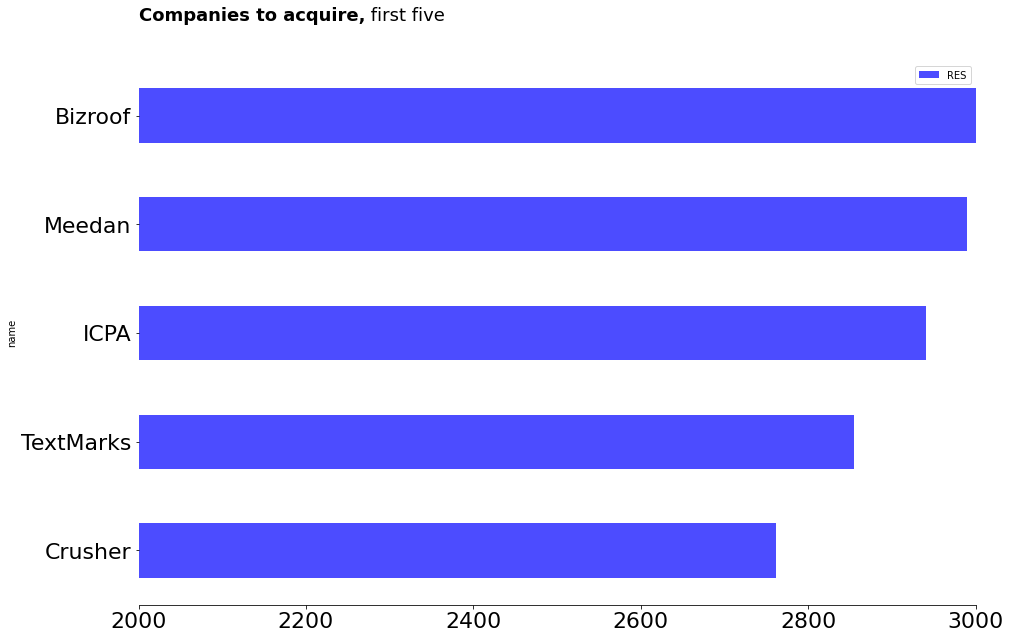

In [598]:
ax = df_final[['RES']].plot(kind='barh', figsize=(15, 10), legend=True, fontsize=22,color='blue', alpha=0.7, linewidth=40)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xlim(2000, 3000)

text = "<size:18><weight:bold>Companies to acquire,</> first five</>"
flexitext(0, 1.1, text, va="top", ax=ax);


plt.show();

# CONCLUSION

Finally, the company I selected to acquire is the one with the minimun sum of the weighted factors is Crusher.